In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import torch.optim as optim


np.random.seed(140)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
mod_press = np.genfromtxt('mod_pressure.csv', delimiter=',')
volum = np.genfromtxt('volum.csv', delimiter=',')
temp = np.genfromtxt('temp.csv', delimiter=',')
volums = []
for v in volum:
    k = [v for i in range(len(mod_press)//len(volum))]
    volums += k
len(volums)
volum = np.array(volums)
import scipy as sc
argans_radius = 0.1 * 1e-9
particle_radius = 2.0
vol_change_rate = argans_radius / particle_radius
# So now my dim in these terms is: new_dim = dim * vol_change_rate
V = volum * vol_change_rate**2
sim_n = 500
N_A = sc.constants.Avogadro # Avogadro constant
N = 225 # The number of molecules
molar_v = (V * N_A / N)
# molar_v = molar_v / 1000.0

R = sc.constants.R   # universtal gas constant
b = 4 * (sc.constants.pi * (argans_radius)**2) * N_A

a = 50
T = temp # Temp
# p_ideal = (sc.constants.R * T) / molar_v
# print(f'p ideal is {p_ideal} and measured pressure is {pressure}')
# p_vdw = ((sc.constants.R * T) / (molar_v - b)) - (a / (molar_v**2))
# p_vdw_noisy = p_vdw + np.random.normal(0, 0.6, len(p_vdw))
# input = {'molar_v': molar_v, 'T': T}

In [31]:
df = pd.DataFrame(data={'v':molar_v, 'temprature':T})
nparray = df.values

X_train = torch.from_numpy(nparray)
y_train = torch.from_numpy(mod_press)

In [32]:
mod_press.min()

0.12414460584262006

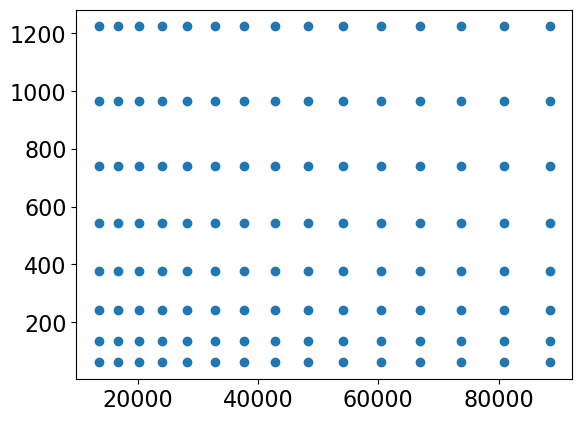

In [33]:
plt.scatter(molar_v, T)

In [34]:
print(f'molar v min:{molar_v.min()}, max:{molar_v.max()}')

molar v min:13549.816710000005, max:88492.01283444448


In [70]:
v_moredata = torch.linspace(13549.81, 54199.26684, 30)
result_cartesian = torch.cartesian_prod(v_moredata,X_train[:,1])
result_cartesian


tensor([[13549.8100,    60.4560],
        [13549.8100,   136.0261],
        [13549.8100,   241.8241],
        ...,
        [54199.2668,   740.5863],
        [54199.2668,   967.2964],
        [54199.2668,  1224.2345]])

In [53]:
result_cartesian.shape

torch.Size([3600, 2])

In [36]:
print(f'T min:{T.min()}, max:{T.max()}')

T min:60.456022829558115, max:1224.2344622985518


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


DTYPE = torch.float64
torch.set_default_dtype(torch.float64)
# Frozen IdealGasLaw model
class IdealGasLaw(nn.Module):
    def __init__(self):
        super(IdealGasLaw, self).__init__()
        self.R = nn.Parameter(torch.tensor([193.39], dtype=DTYPE))
        
    def forward(self, x):
        v = x[:, 0]
        t = x[:, 1]
        p = self.R * t / v
        return torch.reshape(p, (-1,))

# Freeze IdealGasLaw weights
ideal_gas_model = IdealGasLaw()
# for param in ideal_gas_model.parameters():
#     param.requires_grad = False

# Correction network - smaller for limited data
class CorrectionNetwork(nn.Module):
    def __init__(self, input_size=2, hidden_size=32):
        super(CorrectionNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.BatchNorm1d(input_size),
            nn.Tanh()  # Constrains corrections within a range
        )
        
        # Scale factors based on your data ranges
        # These will multiply the tanh output to get appropriate scale of corrections
        v_range = 88492.0 - 13550.0
        t_range = 1224.0 - 60.0
        self.scale_factors = nn.Parameter(torch.tensor([v_range/10, t_range/10]), requires_grad=True)
        
    def forward(self, x):
        # Get base corrections from network (-1 to 1 from tanh)
        base_corrections = self.network(x)
        # Scale the corrections appropriately for each dimension
        scaled_corrections = base_corrections * self.scale_factors
        return scaled_corrections

# Combined model
class CombinedModel(nn.Module):
    def __init__(self, ideal_gas_model, correction_network):
        super(CombinedModel, self).__init__()
        self.ideal_gas_model = ideal_gas_model
        self.correction_network = correction_network
        
        for param in ideal_gas_model.parameters():
            param.requires_grad = False
        
        
    def forward(self, x):
        corrections = self.correction_network(x)
        corrected_input = x + corrections
        pressure = self.ideal_gas_model(corrected_input)
        return pressure, corrections, corrected_input

# Custom loss with regularization for small dataset
def custom_loss(predicted_pressure, target_pressure, corrections, lambda_reg=0.000001):
    # Pressure prediction accuracy
    pressure_loss = nn.MSELoss()(predicted_pressure, target_pressure)
    # print(f'correction shape:{corrections.shape}, .sum shape {torch.sum(corrections.abs(), dim=1).shape}')
    # Minimal correction regularization
    correction_magnitude = torch.mean(torch.sum(corrections.abs(), dim=1))
    
    return pressure_loss, correction_magnitude, pressure_loss + lambda_reg * correction_magnitude

# Set up data
def prepare_data(v_values, t_values, p_values, batch_size=128):
    # Convert to tensors
    v_tensor = torch.tensor(v_values, dtype=torch.float64).reshape(-1, 1)
    t_tensor = torch.tensor(t_values, dtype=torch.float64).reshape(-1, 1)
    p_tensor = torch.tensor(p_values, dtype=torch.float64)
    
    # Combine v and t into input features
    x = torch.cat([v_tensor, t_tensor], dim=1)

    # Create dataset and dataloader
    dataset = TensorDataset(x, p_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader

optimizer = optim.Adam(ideal_gas_model.parameters(), lr=0.01, weight_decay=1e-6)
pressure_loss = nn.MSELoss()

# Training function
def train(model, dataloader, epochs=300):
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in dataloader:
            # Forward pass
            predicted_pressure, corrections, corrected_inputs = model(inputs)
            
            # Calculate loss
            p_loss, correc_loss, loss = custom_loss(predicted_pressure, targets, corrections)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        
        # Print progress less frequently
        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.6f}=p_loss:{p_loss/len(dataloader)} + c_loss:{correc_loss/len(dataloader)}')
            
            # Print example corrections for monitoring
            if epoch + 1 == epochs:
                with torch.no_grad():
                    sample_inputs = next(iter(dataloader))[0][:3]  # Get 3 samples
                    _, sample_corrections, corrected = model(sample_inputs)
                    print("Sample original inputs:", sample_inputs)
                    print("Sample corrections:", sample_corrections)
                    print("Sample corrected inputs:", corrected)
    
    return losses




In [8]:
m2 = IdealGasLaw()
# optimizer = optim.Adam(m2.parameters(), lr=0.01, weight_decay=1e-6)
# pressure_loss = nn.MSELoss()
# for epoch in range(10000):
#     optimizer.zero_grad()
#     p = m2(X_train[40:])
#     loss = pressure_loss(p, y_train[40:])
#     loss.backward()
#     optimizer.step()
    
#     print(f'epoch {epoch}, loss:{loss}')



In [38]:
m2.eval()

IdealGasLaw()

In [39]:
for name, param in m2.named_parameters():
    print(f"Parameter: {name}, Value: {param.data}")

Parameter: R, Value: tensor([193.3998])


In [40]:
correction_network = CorrectionNetwork()
combined_model = CombinedModel(ideal_gas_model=m2, correction_network=correction_network)
combined_model.load_state_dict(torch.load('finalcombined.pth'))
combined_model.eval()

CombinedModel(
  (ideal_gas_model): IdealGasLaw()
  (correction_network): CorrectionNetwork(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=32, out_features=2, bias=True)
      (4): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
    )
  )
)

In [25]:
# dataloader = prepare_data(molar_v, T, mod_press)
# losses = train(combined_model, dataloader, epochs=100000)

In [96]:
# torch.save(combined_model.state_dict(), 'finalcombined.pth')

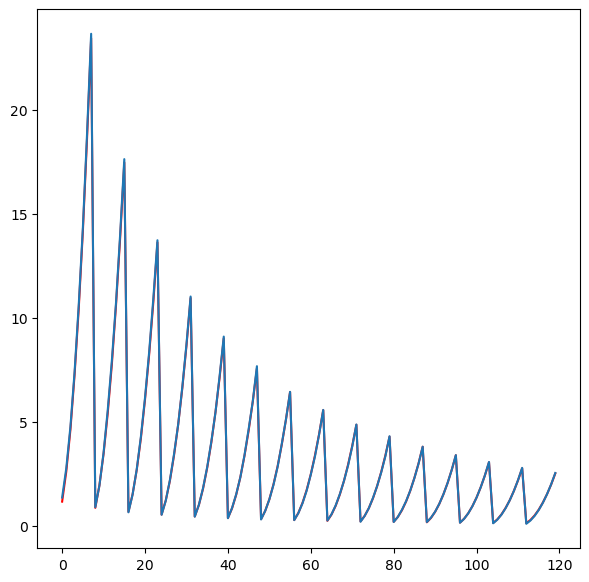

In [13]:

combined_model.eval()
with torch.no_grad():
    plt.figure(figsize=(7,7))
    plt.plot(y_train, color='r')
    plt.plot(combined_model(X_train)[0])

In [80]:

with torch.no_grad():
    pressure_predicted_combined = combined_model(X_train)[0]
    pressure_more_data = combined_model(result_cartesian)[0]
    pressure_predicted_combined = pressure_predicted_combined.numpy()
    pressure_predicted_combined_moredata = pressure_more_data.numpy()
    pressure_predicted_idealgas = m2(X_train).numpy()
    
    pressure_predicted_idealgas_moredata = m2(result_cartesian).numpy()
    corrected_input = combined_model(X_train)[2]
    correction = combined_model(X_train)[1]

In [72]:
corrected_index = correction[:,0].abs()>100

In [73]:
X_train_corrected = X_train[corrected_index]
corrected_input_selected = corrected_input[corrected_index]

In [74]:
len(X_train_corrected)

34

/tmp/ipykernel_6571/2870101938.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('idealgasdata_changed.pdf', dpi=1500, format='pdf')


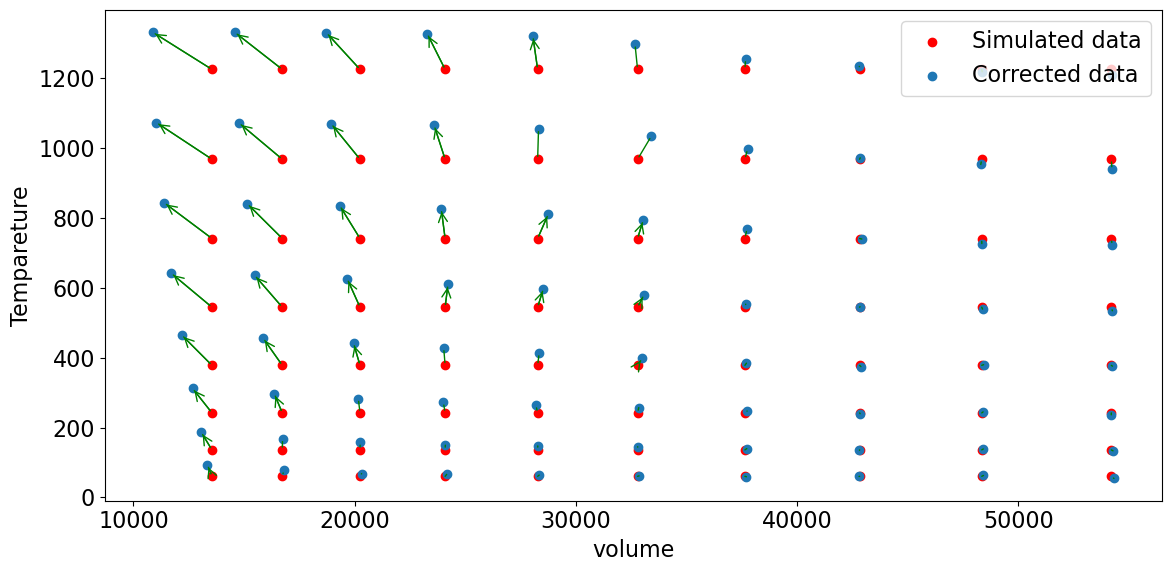

In [44]:
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 16
plt.scatter(X_train[:-40,0], X_train[:-40,1], color='red',label='Simulated data')
# plt.scatter(corrected_input[:,0], corrected_input[:,1])
for i in range(len(X_train_corrected)-5):
    plt.annotate('', xytext=(X_train_corrected[i, 0], X_train_corrected[i, 1]), 
              xy=(corrected_input_selected[i, 0], corrected_input_selected[i, 1]), 
            arrowprops=dict(arrowstyle='->', color='green', lw=1.0))

for i in range(len(X_train)-40):
    plt.annotate('', xytext=(X_train[i, 0], X_train[i, 1]), 
              xy=(corrected_input[i, 0], corrected_input[i, 1]), 
            arrowprops=dict(arrowstyle='-', color='green', lw=1.0))
plt.scatter(corrected_input[:-40,0], corrected_input[:-40,1], label='Corrected data')
plt.xlabel('volume')
plt.ylabel('Tempareture')
plt.legend()
plt.tight_layout()
plt.savefig('idealgasdata_changed.pdf', dpi=1500, format='pdf')
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 16
plt.scatter(X_train[:-40,0], X_train[:-40,1], color='red',label='Simulated data')
# plt.scatter(corrected_input[:,0], corrected_input[:,1])
for i in range(len(X_train)-40):
    plt.arrow(X_train[i, 0], X_train[i, 1], 
              corrected_input[i, 0] - X_train[i, 0], 
              corrected_input[i, 1] - X_train[i, 1], 
            head_width=3, head_length=3,
              fc='green', ec='green', 
              length_includes_head=True,
              alpha=0.7)
plt.scatter(corrected_input[:-40,0], corrected_input[:-40,1], label='Corrected data')
plt.xlabel('volum')
plt.ylabel('Tempareture')
plt.legend()
plt.tight_layout()
plt.show()

In [82]:
data_sim = np.column_stack((T, molar_v, mod_press))
data_toplot = np.column_stack((T, molar_v, pressure_predicted_combined))
data_idealgas = np.column_stack((result_cartesian[:,1].numpy(), result_cartesian[:,0].numpy(), pressure_predicted_idealgas_moredata))
data_moredata = np.column_stack((result_cartesian[:,1].numpy(), result_cartesian[:,0].numpy(), pressure_predicted_combined_moredata))

data_moredata = data_moredata[np.argsort(data_moredata[:,0])]
data_sim = data_sim[np.argsort(data_sim[:,0])]
data_toplot = data_toplot[np.argsort(data_toplot[:,0])]
data_idealgas = data_idealgas[np.argsort(data_idealgas[:,0])]
unique_temps = np.unique(data_toplot[:, 0])
unique_temps_more_data = np.unique(data_moredata[:,0])

54199.26684
54199.26684
54199.26684
54199.26684
54199.26684
54199.26684
54199.26684
54199.26684


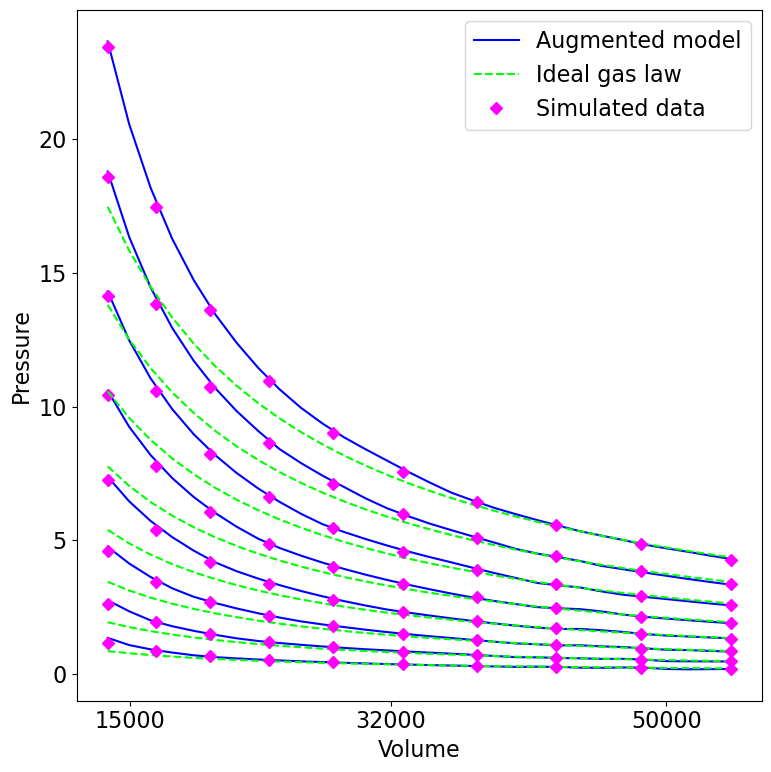

In [85]:
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = 16
count = 0
for temp in unique_temps:
    temp_mask = data_toplot[:, 0] == temp
    v_vals = data_toplot[temp_mask, 1]
    p_vals = data_toplot[temp_mask, 2]
    
 
    
    v_sim = data_sim[temp_mask, 1]
    p_sim = data_sim[temp_mask, 2]
    
    temp_mask = data_moredata[:, 0] == temp
    v_more = data_moredata[temp_mask, 1]
    p_more = data_moredata[temp_mask, 2]
    v_ideal = data_idealgas[temp_mask, 1]
    p_ideal = data_idealgas[temp_mask, 2]
    # Sort by volume for smoother curve
    sorted_sim = np.argsort(v_sim)
    v_sim = v_sim[sorted_sim]
    p_sim = p_sim[sorted_sim]
    
    sorted_idx2 = np.argsort(v_ideal)
    v_ideal = v_ideal[sorted_idx2]
    p_ideal = p_ideal[sorted_idx2]
    
    sorted_idx = np.argsort(v_vals)
    v_vals = v_vals[sorted_idx]
    p_vals = p_vals[sorted_idx]
    
    sorted_idx = np.argsort(v_more)
    v_more = v_more[sorted_idx]
    p_more = p_more[sorted_idx]
    
    
    label_combined = 'Augmented model' if count == 0 else None
    label_ideal = 'Ideal gas law' if count == 0 else None
    label_sim = 'Simulated data' if count == 0 else None
    
    
    plt.plot(v_more[:-5], p_more[:-5], color='blue', label=label_combined)
    plt.plot(v_ideal[:-5], p_ideal[:-5], '--', color='lime', label=label_ideal)
    print(v_ideal[:-5].max())

    plt.plot(v_sim[:-5], p_sim[:-5], 'D', color='magenta', label=label_sim)
    count += 1
    
plt.xlabel('Volume')
plt.ylabel('Pressure')
# plt.xscale('log')
plt.legend()
tick_values = [15000, 32000, 50000]  # or pick values yourself
plt.xticks(tick_values, [str(int(round(v))) for v in tick_values])
# plt.title('Isotherms')
plt.tight_layout()
plt.savefig('isotherms.pdf', dpi=1500, format='pdf')


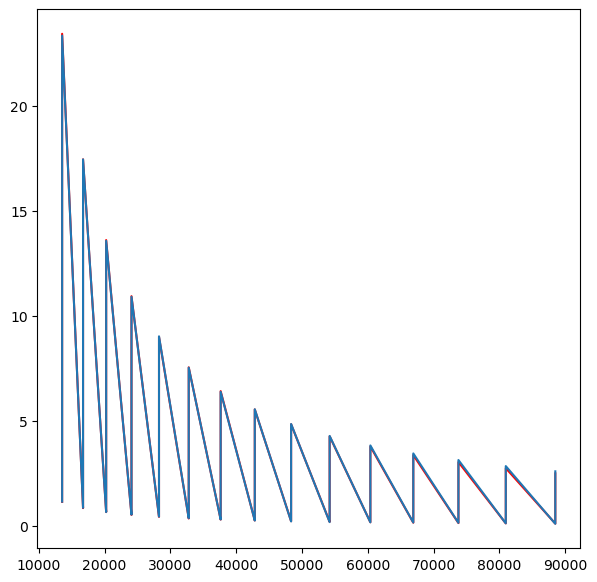

In [12]:
with torch.no_grad():
    plt.figure(figsize=(7,7))
    plt.plot(molar_v, y_train, color='r')
    plt.plot(molar_v, combined_model(X_train)[0])

In [11]:
p_e = y_train - combined_model(X_train)[0]

In [178]:
torch.sum(p_e.abs() > 0.01)

tensor(75)

In [175]:
torch.min(p_e.abs())

tensor(9.9406e-05, grad_fn=<MinBackward1>)

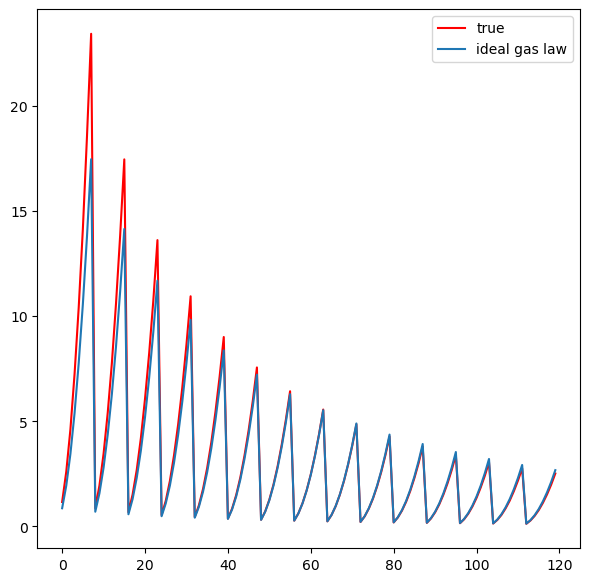

In [30]:
ideal_gas_model.eval()
with torch.no_grad():
    plt.figure(figsize=(7,7))
    plt.plot(y_train, color='r',label="true")
    plt.plot(m2(X_train),label="ideal gas law")
    plt.legend()

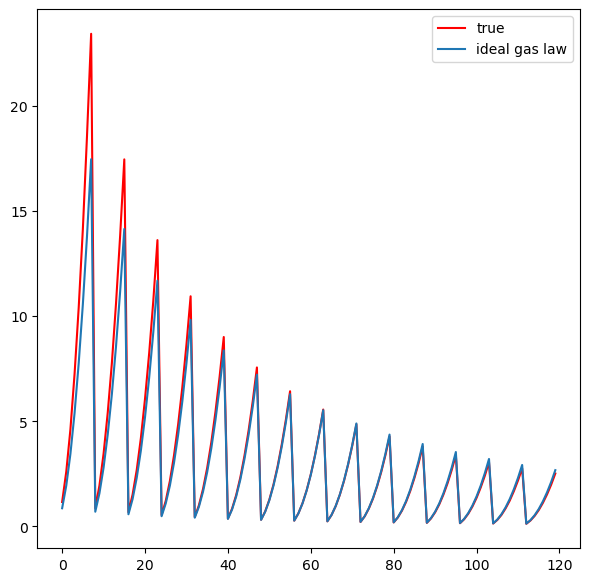

In [31]:
ideal_gas_model.eval()
with torch.no_grad():
    plt.figure(figsize=(7,7))
    plt.plot(y_train, color='r',label="true")
    plt.plot(m2(X_train),label="ideal gas law")
    plt.legend()

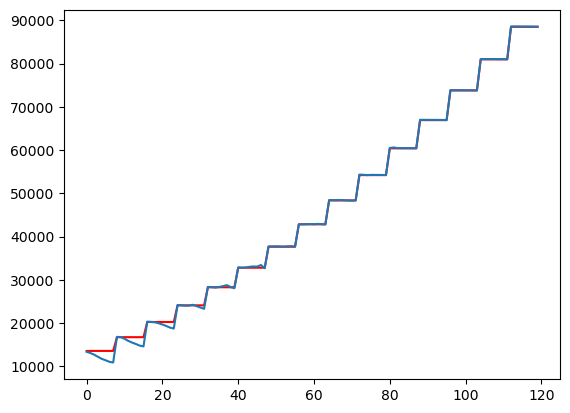

In [32]:
correction_network.eval()
e = correction_network(X_train)
with torch.no_grad():
    plt.plot(molar_v, color='r')
    plt.plot(molar_v+(e[:,0]).numpy())


In [34]:
torch.mean(e[:,0])

tensor(-170.5164, grad_fn=<MeanBackward0>)

In [35]:
torch.mean(e[:,1])

tensor(15.1194, grad_fn=<MeanBackward0>)

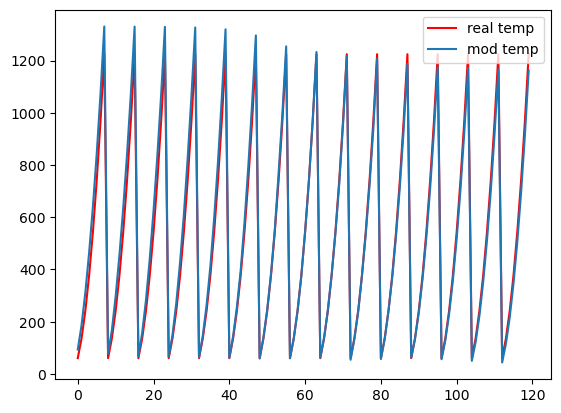

In [33]:
correction_network.eval()
e = correction_network(X_train)
with torch.no_grad():
    plt.plot(T, color='r', label="real temp")
    plt.plot(T+(e[:,1]).numpy(), label="mod temp")
    plt.legend()


Visualization for paper:

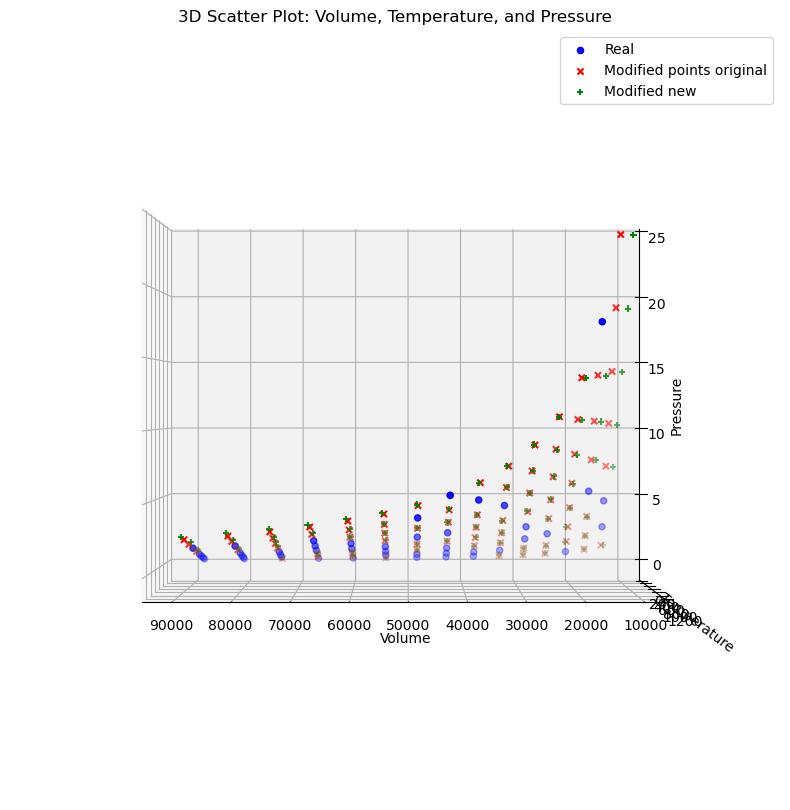

In [186]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Sample data: replace with your actual data
with torch.no_grad():
    v_changed  = molar_v+(e[:,0]).numpy()
    t_changed = T+(e[:,1]).numpy()
    real_pressure = np.random.rand(100)
    modified_pressure = np.random.rand(100)
    p_e = y_train - combined_model(X_train)[0]
    modified = p_e.abs() > 0.01

    # Plotting 3D scatter plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter for real values
    ax.scatter(molar_v[modified == 0], T[modified == 0], y_train[modified == 0], c='blue', label='Real', marker='o')
    # Scatter for modified values
    ax.scatter(molar_v[modified == 1], T[modified == 1], y_train[modified == 1], c='red', label='Modified points original', marker='x')
    ax.scatter(v_changed[modified == 1], t_changed[modified == 1], combined_model(X_train)[0][modified == 1], c='green', label='Modified new', marker='+')
    ax.set_xlabel('Volume')
    ax.set_ylabel('Temperature')
    ax.set_zlabel('Pressure')
    ax.set_title('3D Scatter Plot: Volume, Temperature, and Pressure')
    ax.view_init(elev=0, azim=90)
    ax.legend()

    plt.show()


In [149]:
for name, param in correction_network.named_parameters():
    print(f"Parameter: {name}, Value: {param.data}")

Parameter: scale_factors, Value: tensor([7491.2008,  113.8164])
Parameter: network.0.weight, Value: tensor([[ 0.3641,  0.0328],
        [-0.1828, -0.3367],
        [-0.2021, -0.0156],
        [-0.0527, -0.2188],
        [-0.0025, -0.2797],
        [-0.5528, -0.2361],
        [-0.2590, -0.4372],
        [ 0.0325, -0.8875],
        [-0.0050, -0.3214],
        [-0.4401,  0.2314],
        [ 0.0505, -0.5072],
        [-0.2250,  0.5428],
        [ 0.3145, -0.0048],
        [-0.2717, -0.3476],
        [-0.2548, -0.3637],
        [ 0.3568, -0.1947],
        [ 0.1532,  0.6721],
        [ 0.0223, -0.7646],
        [ 0.0073,  0.2849],
        [-0.0524,  0.6099],
        [-0.1418,  0.1308],
        [ 0.3854, -0.6544],
        [-0.0795,  0.3451],
        [-0.2955,  0.5485],
        [ 0.5321,  0.4238],
        [-0.1633,  0.0078],
        [ 0.2532,  0.7153],
        [ 0.4048,  0.7341],
        [ 0.1953, -0.7492],
        [ 0.1493,  0.1504],
        [ 0.4411, -0.0073],
        [-0.0462,  0.0512]])
Par

In [165]:
# torch.save(combined_model.state_dict(), 'combinedmodelstatedict_best2.pth')
# torch.save(ideal_gas_model.state_dict(), 'idealgasworking_best2.pth')
# torch.save(correction_network, 'correctionnetworkstatedict_best2.pth')

Saving models:

In [ ]:
# torch.save(combined_model.state_dict(), 'somewhatworkingcombinedmodelstatedict.pth')
# torch.save(ideal_gas_model.state_dict(), 'idealgasworking.pth')
# torch.save(correction_network, 'somewhatworkingcorrectionnetworkstatedict.pth')

my buggy version

In [6]:
class IdealGasLaw(nn.Module):
    def __init__(self):
        super(IdealGasLaw, self).__init__()
        self.R = nn.Parameter(torch.tensor([210.0]))
        
    def forward(self, x):
        v = x[:, 0]
        t = x[:, 1]
        p = self.R * t / v
        return torch.reshape(p, (-1,))

In [7]:
idealgaslaw = IdealGasLaw().to(device)

In [8]:
prediction_criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(idealgaslaw.parameters(), lr=0.005)
for epoch in range(1000):
    idealgaslaw.train()
    optimizer.zero_grad()
    p = idealgaslaw(X_train)
    loss = prediction_criterion(p, y_train)
    loss.backward()
    optimizer.step()
    print(f'epock {epoch}, loss={loss}')

epock 0, loss=63.68988735177931
epock 1, loss=63.677440553170285
epock 2, loss=63.66499697369217
epock 3, loss=63.652556613345084
epock 4, loss=63.640119472129086
epock 5, loss=63.627685550044035
epock 6, loss=63.61525484709006
epock 7, loss=63.60282736326701
epock 8, loss=63.59040309857505
epock 9, loss=63.577982053014104
epock 10, loss=63.56556422658415
epock 11, loss=63.55314961928524
epock 12, loss=63.5407382311173
epock 13, loss=63.52833006208042
epock 14, loss=63.515925112174514
epock 15, loss=63.50352338139966
epock 16, loss=63.49116266520393
epock 17, loss=63.47880514854029
epock 18, loss=63.466450831408736
epock 19, loss=63.45409971380927
epock 20, loss=63.441751795741936
epock 21, loss=63.42940707720662
epock 22, loss=63.41706555820347
epock 23, loss=63.40472723873236
epock 24, loss=63.39239211879335
epock 25, loss=63.38006019838643
epock 26, loss=63.367731477511626
epock 27, loss=63.35540595616888
epock 28, loss=63.34308363435821
epock 29, loss=63.33076451207968
epock 30, lo

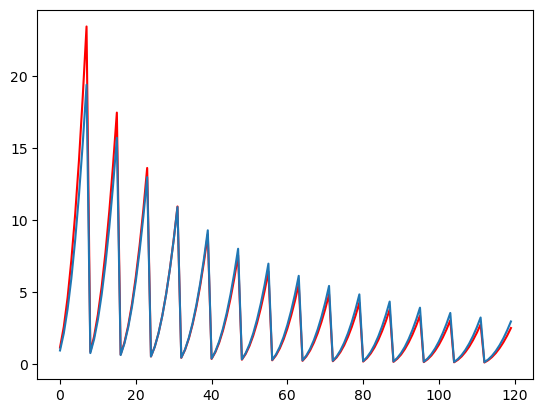

In [9]:
idealgaslaw.eval()
with torch.no_grad():
    plt.plot(y_train, color='r')
    plt.plot(idealgaslaw(X_train))

In [10]:
for name, param in idealgaslaw.named_parameters():
    print(f"{name}: {param.data}")


R: tensor([214.7073])


In [40]:
idealgaslaw.eval()

IdealGasLaw()

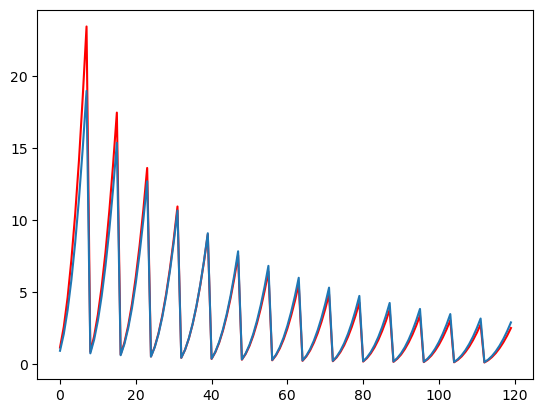

In [41]:
idealgaslaw.eval()
with torch.no_grad():
    plt.plot(mod_press, color='r')
    plt.plot(idealgaslaw(X_train))

In [11]:
import torch.nn.init as init

In [12]:
class InputTransformer(nn.Module):
    def __init__(self, input_dim):
        super(InputTransformer, self).__init__()
        
        # self.input_dim = input_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim, 4),
            nn.LeakyReLU(0.1),
            nn.Linear(4, input_dim),
            nn.Tanh()
        )
        
        self._initialize_weights()
        
    def forward(self, x):
        change = 10000*self.net(x)
        
        return x + change
    
    def _initialize_weights(self):
    # Initialize weights for each Linear layer
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                # Xavier initialization (uniform distribution)
                init.xavier_uniform_(layer.weight)  # You can also use init.xavier_normal_()
                
                # Initialize biases to zeros
                if layer.bias is not None:
                    init.zeros_(layer.bias)


class CombinedModel(nn.Module):
    def __init__(self, idealgas, transformer):
        super(CombinedModel, self).__init__()
        
        self.idealgas = idealgas
        self.transformer = transformer
        
        
        for param in self.idealgas.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        change = self.transformer(x)

        # new_input = x + change
        
        p = self.idealgas(change)
        
        return {
            'change' : change,
            'output' : torch.reshape(p, (-1,))
        }

In [13]:
torch.set_default_dtype(torch.float64)
input_transformer = InputTransformer(input_dim=2).to(device)
combined_model = CombinedModel(idealgas=idealgaslaw, transformer=input_transformer).to(device)

In [19]:
torch.sum((y_train - combined_model(X_train)['output'])**2)

tensor(330484.5419, grad_fn=<SumBackward0>)

In [20]:
optimizer = optim.Adam(combined_model.transformer.parameters(), lr=0.005)
prediction_criterion = nn.MSELoss(reduction='sum')
mse_criterion = nn.MSELoss()
train_losses = []
print("Training the combined model")
num_epochs = 1300
for epoch in range(num_epochs):
    combined_model.transformer.train()
    

    
    # optimizer.zero_grad()
    
    outputs = combined_model(X_train)
    classifier_loss = torch.sum((outputs['output']-y_train)**2)
    loss = classifier_loss + 5 * torch.norm(outputs['change'], p=2)
    
    loss.backward()
        # Monitor gradients
    for name, param in combined_model.transformer.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            print(f"Gradient norm for {name}: {grad_norm}")
        else:
            print(f"{name} has no gradient")
    optimizer.step()
    
    train_losses.append(loss)
    if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}=class: {classifier_loss} + norm: {5 * torch.norm(outputs["change"], p=2)}')
            
            

Training the combined model
Gradient norm for net.0.weight: 0.0
Gradient norm for net.0.bias: 0.0
Gradient norm for net.2.weight: 0.0
Gradient norm for net.2.bias: 0.0
Gradient norm for net.0.weight: 0.0
Gradient norm for net.0.bias: 0.0
Gradient norm for net.2.weight: 0.0
Gradient norm for net.2.bias: 0.0
Gradient norm for net.0.weight: 0.0
Gradient norm for net.0.bias: 0.0
Gradient norm for net.2.weight: 0.0
Gradient norm for net.2.bias: 0.0
Gradient norm for net.0.weight: 0.0
Gradient norm for net.0.bias: 0.0
Gradient norm for net.2.weight: 0.0
Gradient norm for net.2.bias: 0.0
Gradient norm for net.0.weight: 0.0
Gradient norm for net.0.bias: 0.0
Gradient norm for net.2.weight: 0.0
Gradient norm for net.2.bias: 0.0
Gradient norm for net.0.weight: 0.0
Gradient norm for net.0.bias: 0.0
Gradient norm for net.2.weight: 0.0
Gradient norm for net.2.bias: 0.0
Gradient norm for net.0.weight: 0.0
Gradient norm for net.0.bias: 0.0
Gradient norm for net.2.weight: 0.0
Gradient norm for net.2.bi

In [23]:
print(outputs['change'])
print(len(outputs['change']))

tensor([[-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -10000.],
        [-10000., -1

In [97]:
X_train.dtype

torch.float64

In [155]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Data Preparation and Scaling
def prepare_data(volum, temp, mod_press):
    """
    Prepare and scale the data for model training.
    
    Args:
        volum: Volume data
        temp: Temperature data
        mod_press: Pressure data
        
    Returns:
        Scaled data and scalers for later use
    """
    # Create DataFrame
    df = pd.DataFrame(data={'v': volum, 'temperature': temp})
    
    # Scale input features
    input_scaler = StandardScaler()
    X_scaled = input_scaler.fit_transform(df.values)
    
    # Scale target
    output_scaler = StandardScaler()
    y_scaled = output_scaler.fit_transform(mod_press.reshape(-1, 1))
    
    # Convert to PyTorch tensors
    X_train = torch.tensor(X_scaled, dtype=torch.float64).to(device)
    y_train = torch.tensor(y_scaled, dtype=torch.float64).to(device)
    
    return X_train, y_train, input_scaler, output_scaler

# 2. Ideal Gas Law Model
class IdealGasLaw(nn.Module):
    def __init__(self):
        super(IdealGasLaw, self).__init__()
        self.R = nn.Parameter(torch.tensor([230.0], dtype=torch.float64))
        
    def forward(self, x):
        v = x[:, 0]
        t = x[:, 1]
        p = self.R * t / v
        return torch.reshape(p, (-1, 1))

# 3. Input Transformer with scaling already built in
class InputTransformer(nn.Module):
    def __init__(self, input_dim):
        super(InputTransformer, self).__init__()
        self.input_dim = input_dim
        
        # Network architecture with batch normalization
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, self.input_dim),
            nn.Tanh()
        )
        
    def forward(self, x):
        # Apply transformation with adjustable magnitude
        # Using a smaller scaling factor for more stable training
        x = self.net(x)
        return x

# 4. Combined Model
class CombinedModel(nn.Module):
    def __init__(self, idealgas, transformer):
        super(CombinedModel, self).__init__()
        
        self.idealgas = idealgas
        self.transformer = transformer
        
        # Freeze the ideal gas law parameters
        for param in self.idealgas.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        change = self.transformer(x)
        
        new_input = x + change
        
        p = self.idealgas(new_input)
        
        return {
            'change': change,
            'output': p
        }

# 5. Training Function
def train_models(X_train, y_train, num_epochs_initial=20000, num_epochs_combined=20000):
    """
    Train both the IdealGasLaw model and the combined model.
    
    Args:
        X_train: Scaled input data
        y_train: Scaled target data
        num_epochs_initial: Number of epochs for training the initial model
        num_epochs_combined: Number of epochs for training the combined model
        
    Returns:
        Trained models and training losses
    """
    # # First train the Ideal Gas Law model
    idealgaslaw = IdealGasLaw().to(device)
    criterion = nn.SmoothL1Loss(reduction='sum')
    optimizer = optim.Adam(idealgaslaw.parameters(), lr=0.005)

    initial_losses = []
    print("Training the Ideal Gas Law model...")

    for epoch in range(num_epochs_initial):
        p = idealgaslaw(X_train)
        train_loss = criterion(p, y_train)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        initial_losses.append(train_loss.item())
        
        if (epoch+1) % 2000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs_initial}], Train Loss: {train_loss.item():.4f}')
    
    # Set model to evaluation mode
    idealgaslaw.eval()
    
    # Train the combined model
    input_transformer = InputTransformer(input_dim=2).to(device)
    combined_model = CombinedModel(idealgas=idealgaslaw, transformer=input_transformer).to(device)
    
    # Use Adam optimizer with learning rate decay
    optimizer = optim.Adam(combined_model.transformer.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, factor=0.5)
    
    prediction_criterion = nn.MSELoss(reduction='sum')
    combined_losses = []
    
    print("\nTraining the combined model...")
    for epoch in range(num_epochs_combined):
        combined_model.transformer.train()
        
        optimizer.zero_grad()
        
        outputs = combined_model(X_train)
        prediction_loss = prediction_criterion(outputs['output'], y_train)
        
        # Add regularization term to prevent extreme transformations
        regularization = 0.5 * torch.norm(outputs["change"], p=2)
        loss = prediction_loss + regularization
        
        loss.backward()
        optimizer.step()
        
        # Update learning rate based on loss
        scheduler.step(loss)
        
        combined_losses.append(loss.item())
        
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs_combined}], Train Loss: {loss.item():.4f} = '
                  f'Prediction: {prediction_loss.item():.4f} + Reg: {regularization.item():.4f}')
    
    return idealgaslaw, combined_model, initial_losses, combined_losses

# 6. Visualization Function
def plot_results(initial_losses, combined_losses):
    """Plot training losses for both models."""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(initial_losses)
    plt.title('Ideal Gas Law Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    
    plt.subplot(1, 2, 2)
    plt.plot(combined_losses)
    plt.title('Combined Model Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

def main(volum, temp, mod_press):
    """Main function to run the entire training pipeline."""
    # Set default dtype
    torch.set_default_dtype(torch.float64)
    
    # Prepare and scale data
    X_train, y_train, input_scaler, output_scaler = prepare_data(volum, temp, mod_press)
    
    # Train models
    idealgaslaw, combined_model, initial_losses, combined_losses = train_models(X_train, y_train)
    
    # Plot training results
    plot_results(initial_losses, combined_losses)
    
    # Visualize the transformations
    visualize_transformations(X_train, combined_model, input_scaler)
    
    # Return trained models and scalers for later use
    return idealgaslaw, combined_model, input_scaler, output_scaler

In [156]:
# Function to visualize the transformations
def visualize_transformations(X_train, combined_model, input_scaler):
    """
    Visualize how the transformer modifies the input variables.
    
    Args:
        X_train: Scaled input data
        combined_model: Trained combined model
        input_scaler: Scaler used for the inputs
    """
    # Set model to evaluation mode
    combined_model.eval()
    
    # Get the transformed inputs
    with torch.no_grad():
        outputs = combined_model(X_train)
        changes = outputs['change'].cpu().numpy()
        modified_inputs = (X_train + outputs['change']).cpu().numpy()
    
    # Get original inputs (unscale the data)
    original_inputs = input_scaler.inverse_transform(X_train.cpu().numpy())
    
    # Unscale the modified inputs
    modified_inputs_unscaled = input_scaler.inverse_transform(modified_inputs)
    
    # Plot volume comparisons
    plt.figure(figsize=(14, 10))
    
    # Plot original vs modified volume
    plt.subplot(2, 2, 1)
    plt.scatter(range(len(original_inputs)), original_inputs[:, 0], label='Original Volume', alpha=0.7)
    plt.scatter(range(len(modified_inputs_unscaled)), modified_inputs_unscaled[:, 0], 
                label='Modified Volume', alpha=0.7)
    plt.xlabel('Sample Index')
    plt.ylabel('Volume')
    plt.title('Original vs Modified Volume')
    plt.legend()
    
    # Plot volume changes
    plt.subplot(2, 2, 2)
    plt.bar(range(len(original_inputs)), 
            modified_inputs_unscaled[:, 0] - original_inputs[:, 0])
    plt.xlabel('Sample Index')
    plt.ylabel('Volume Change')
    plt.title('Volume Modifications')
    
    # Plot original vs modified temperature
    plt.subplot(2, 2, 3)
    plt.scatter(range(len(original_inputs)), original_inputs[:, 1], label='Original Temperature', alpha=0.7)
    plt.scatter(range(len(modified_inputs_unscaled)), modified_inputs_unscaled[:, 1], 
                label='Modified Temperature', alpha=0.7)
    plt.xlabel('Sample Index')
    plt.ylabel('Temperature')
    plt.title('Original vs Modified Temperature')
    plt.legend()
    
    # Plot temperature changes
    plt.subplot(2, 2, 4)
    plt.bar(range(len(original_inputs)), 
            modified_inputs_unscaled[:, 1] - original_inputs[:, 1])
    plt.xlabel('Sample Index')
    plt.ylabel('Temperature Change')
    plt.title('Temperature Modifications')
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualization: 2D scatter plot showing before/after
    plt.figure(figsize=(10, 8))
    plt.scatter(original_inputs[:, 0], original_inputs[:, 1], 
                label='Original Points', alpha=0.7)
    plt.scatter(modified_inputs_unscaled[:, 0], modified_inputs_unscaled[:, 1], 
                label='Modified Points', alpha=0.7)
    
    # Draw arrows from original to modified points
    for i in range(len(original_inputs)):
        plt.arrow(original_inputs[i, 0], original_inputs[i, 1],
                  modified_inputs_unscaled[i, 0] - original_inputs[i, 0],
                  modified_inputs_unscaled[i, 1] - original_inputs[i, 1],
                  head_width=0.02*(max(original_inputs[:, 0])-min(original_inputs[:, 0])),
                  head_length=0.02*(max(original_inputs[:, 1])-min(original_inputs[:, 1])),
                  fc='k', ec='k', alpha=0.3)
    
    plt.xlabel('Volume')
    plt.ylabel('Temperature')
    plt.title('Input Space Transformations')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    # Calculate and print summary statistics of the transformations
    volume_changes = modified_inputs_unscaled[:, 0] - original_inputs[:, 0]
    temp_changes = modified_inputs_unscaled[:, 1] - original_inputs[:, 1]
    
    print(f"Volume changes - Mean: {np.mean(volume_changes):.4f}, Max: {np.max(volume_changes):.4f}, Min: {np.min(volume_changes):.4f}")
    print(f"Temperature changes - Mean: {np.mean(temp_changes):.4f}, Max: {np.max(temp_changes):.4f}, Min: {np.min(temp_changes):.4f}")
    
    # Calculate relative changes (% of original value)
    rel_volume_changes = 100 * volume_changes / original_inputs[:, 0]
    rel_temp_changes = 100 * temp_changes / original_inputs[:, 1]
    
    print(f"Relative volume changes (%) - Mean: {np.mean(rel_volume_changes):.2f}%, Max: {np.max(rel_volume_changes):.2f}%, Min: {np.min(rel_volume_changes):.2f}%")
    print(f"Relative temperature changes (%) - Mean: {np.mean(rel_temp_changes):.2f}%, Max: {np.max(rel_temp_changes):.2f}%, Min: {np.min(rel_temp_changes):.2f}%")

Training the Ideal Gas Law model...
Epoch [2000/20000], Train Loss: 51595.8481
Epoch [4000/20000], Train Loss: 49249.5986
Epoch [6000/20000], Train Loss: 46903.3490
Epoch [8000/20000], Train Loss: 44557.0995
Epoch [10000/20000], Train Loss: 42210.8500
Epoch [12000/20000], Train Loss: 39864.6005
Epoch [14000/20000], Train Loss: 37518.3510
Epoch [16000/20000], Train Loss: 35172.1015
Epoch [18000/20000], Train Loss: 32825.8519
Epoch [20000/20000], Train Loss: 30479.6024

Training the combined model...
Epoch [100/20000], Train Loss: 19963334.5226 = Prediction: 19963332.3165 + Reg: 2.2060
Epoch [200/20000], Train Loss: 13527773.7870 = Prediction: 13527771.4943 + Reg: 2.2927
Epoch [300/20000], Train Loss: 9371409.8204 = Prediction: 9371407.3687 + Reg: 2.4517
Epoch [400/20000], Train Loss: 7004349.4158 = Prediction: 7004346.8346 + Reg: 2.5813
Epoch [500/20000], Train Loss: 5784651.1500 = Prediction: 5784648.4189 + Reg: 2.7311
Epoch [600/20000], Train Loss: 4924509.3095 = Prediction: 4924506.4

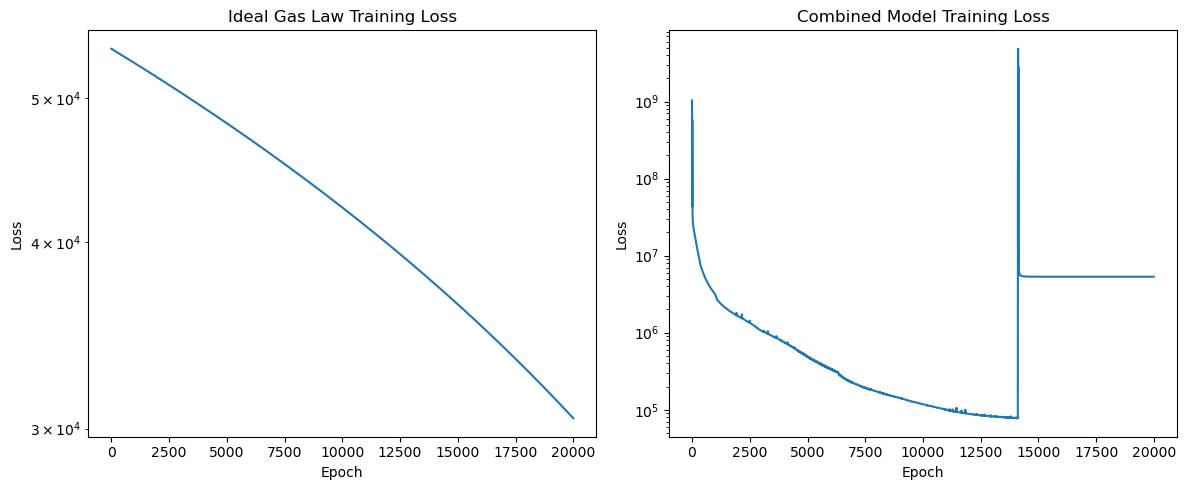

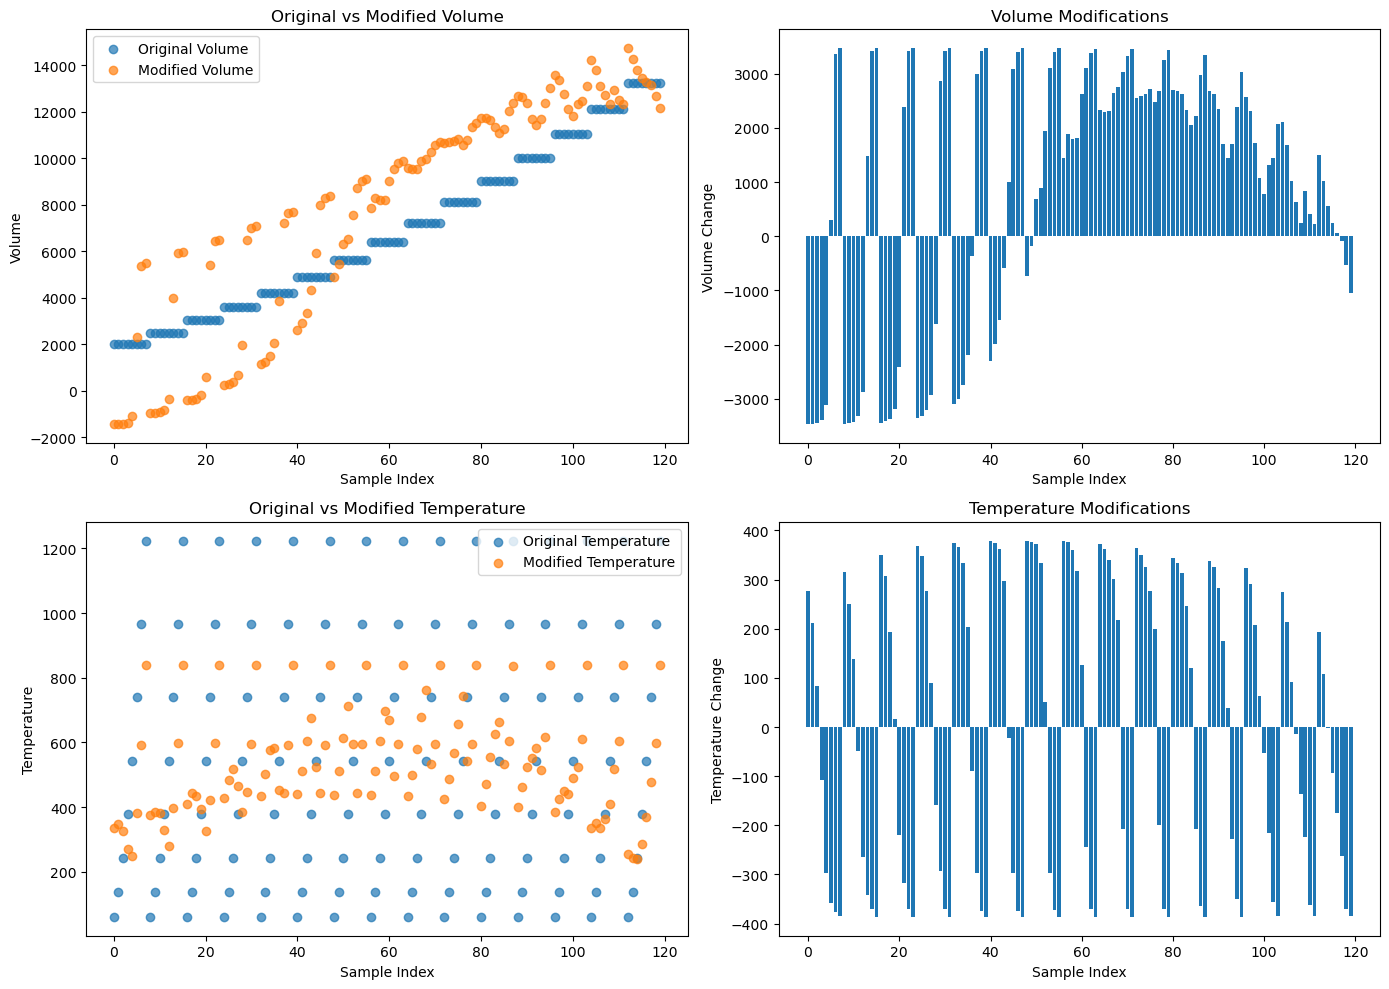

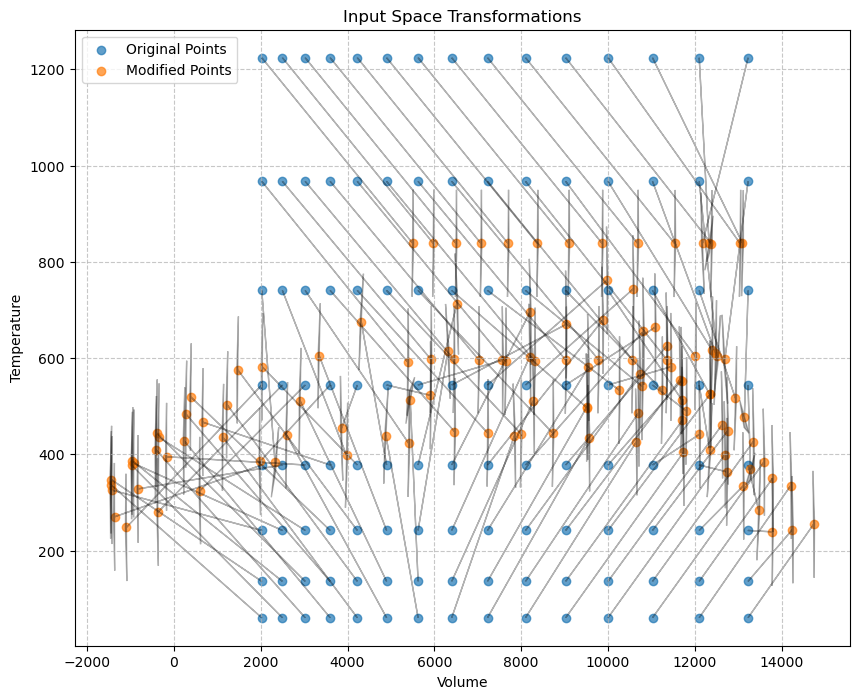

Volume changes - Mean: 929.6406, Max: 3473.4530, Min: -3472.3462
Temperature changes - Mean: -4.8770, Max: 379.2705, Min: -386.3100
Relative volume changes (%) - Mean: 5.15%, Max: 171.53%, Min: -171.47%
Relative temperature changes (%) - Mean: 100.55%, Max: 627.35%, Min: -54.39%


In [157]:
# Assuming you have your data in volum, temp, and mod_press
idealgaslaw, combined_model, input_scaler, output_scaler = main(volum, temp, mod_press)